# Generalize transects
### Generalize transects to calculate transport in density space through a region that is defined by either (1) transects identified via algorithm or (2) geojson mask

In [656]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [657]:
#Packages 
import numpy as np
import xarray as xr
import cmocean.cm as cmo
import matplotlib.pyplot as plt
import mpas_tools

from geometric_features import GeometricFeatures
from geometric_features import read_feature_collection

from mpas_tools.mesh.mask import compute_mpas_region_masks
from mpas_tools.parallel import create_pool
from mpas_tools.io import write_netcdf

import geojson
import json
import mosaic
import os.path
import mpasregions.sections as mps
import gsw
import warnings 
import glob
from xgcm import Grid

In [658]:
def find_and_sort_transect_edges_and_vertices(ds,mask):
    """
    Find vertices and edges that are on the edge of a mask (aka part of the transect). Then sort them to be in consecutive order.
    Calls the sorted_transect_edges_and_vertices function.
    
    Parameters
    ----------
    ds: xarray.core.dataset.Dataset
        Contains information about ocean model grid coordinates.
    
    mask: xarray.core.dataset.Dataset
        Contains RegionCellMasks created from mpas_tools compute_mpas_region_masks
    
    Returns
    -------
    next_edges: numpy.ndarray
        xr indices of the edges that define a transect now sorted to be in consecutive order
    
    next_vertices: numpy.ndarray
        xr indices of the edges that define a transect now sorted to be in consecutive order    
    """
    # collect all cells, vertices, and edges in the mask
    xr_cells_inside, xr_edges_inside, xr_vertices_inside = mps.xr_inside_mask_info(ds,mask)
    
    # ----- MASK EDGES ON LAND -----
    # find edges where one of the cells on edge is land
    all_edgesOnLand_TWO0 = ds.nEdges.where(np.isin(ds.cellsOnEdge.isel(TWO=0),0))
    all_edgesOnLand_TWO1 = ds.nEdges.where(np.isin(ds.cellsOnEdge.isel(TWO=1),0))
    all_edgesOnLand = np.union1d(all_edgesOnLand_TWO0, all_edgesOnLand_TWO1)
    
    # then get all the edges inside the mask
    # xr_edges_inside
    
    # take the intersection of edges inside the mask and all edges on land
    # give mask edges on land
    mask_edgesOnLand = np.intersect1d(xr_edges_inside, all_edgesOnLand)
    
    # ----- MASK EDGES ON OPEN OCEAN -----
    # identify cells NOT in the mask
    xr_cells_outside = ds.nCells[~np.isin(ds.nCells, xr_cells_inside)]
    n_cells_outside = mps.xr_to_n_idx(xr_cells_outside)
    
    n_cells_inside = mps.xr_to_n_idx(xr_cells_inside)
    
    # condition where one of the cells is inside the mask and the other is outside the mask
    # this gives cells on the border of the mask
    
    condition = (np.isin(ds.cellsOnEdge.isel(TWO=0),n_cells_outside)) & (np.isin(ds.cellsOnEdge.isel(TWO=1),n_cells_inside)) | \
            (np.isin(ds.cellsOnEdge.isel(TWO=0),n_cells_inside)) & (np.isin(ds.cellsOnEdge.isel(TWO=1), n_cells_outside))
    
    all_edgesOnMask = ds.nEdges.where(condition)
    
    # take the intersection of edges that border the mask and the edges inside the mask 
    # (this prevents edges on the border outside of the mask from being counted)
    mask_edgesOnOcean = np.intersect1d(xr_edges_inside, all_edgesOnMask)
    
    # combine the edges on land in the mask with the edges of the mask in the open ocean
    xr_mask_transect_edges = np.union1d(mask_edgesOnLand, mask_edgesOnOcean)
    
    # ----------- FIND ALL VERTICES ON EDGES -----------
    n_mask_transect_vertices = ds.verticesOnEdge.isel(nEdges = np.int32(xr_mask_transect_edges))
    xr_mask_transect_vertices = np.unique(mps.n_to_xr_idx(n_mask_transect_vertices))
    
    next_edges, next_vertices = mps.sorted_transect_edges_and_vertices(ds, xr_mask_transect_edges, xr_mask_transect_vertices)

    return next_edges, next_vertices, xr_mask_transect_edges, xr_mask_transect_vertices

In [659]:
# open mesh and filepaths
# global mesh
mesh_path = '/global/cfs/projectdirs/e3sm/inputdata/ocn/mpas-o/EC30to60E2r2/ocean.EC30to60E2r2.210210.nc'
mesh = xr.open_dataset(mesh_path)
mesh = mesh.assign_coords({
"VertexID": xr.DataArray(mesh.indexToVertexID, dims=('nVertices',)),
})

# global data
bmm_filepath = '/pscratch/sd/b/bmoorema/run_001_062/'
# dso = xr.open_dataset(bmm_filepath + '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStatsMonthly.0063-12-01.nc', decode_timedelta=True)

# open base mask that we will fill with 0s according to the original mask (this new mask will contain cells PLUS their corresponding edges and vertices)
# base_mask = xr.open_dataset('./mpas-o_EC30to60_global_base_mask.nc')


In [660]:
# open datasets with just the variables that we want

months = ['01','02','03','04','05','06','07','08','09','10','11','12']
ds_list = []

prefix = '20210421_sim7_CORE_60to30E2r2.mpaso.hist.am.timeSeriesStats'

year = 3 # int
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for i in range(0,12):
        month = months[i]
        file = prefix + f'Monthly.{str(year).zfill(4)}-{month}-01.nc'
        file_glob = glob.glob(file)
        ds = xr.open_dataset(bmm_filepath + file)[['xtime_startMonthly','timeMonthly_avg_normalVelocity','timeMonthly_avg_potentialDensity','timeMonthly_avg_layerThickness',
                                                   'nCells','nEdges','nVertLevels','nVertLevelsP1']]
        ds_xtime_startMonthly = ds.swap_dims({'Time':'xtime_startMonthly'})
        ds_list.append(ds_xtime_startMonthly)

dss = xr.concat(ds_list,dim='xtime_startMonthly')

In [661]:
ds = mps.add_grid_info_coords(mesh,dss)
ds['lonCell'] = ds.lonCell
ds['lonEdge'] = ds.lonEdge
ds['lonVertex'] = ds.lonVertex

ds['latCell'] = ds.latCell
ds['latEdge'] = ds.latEdge
ds['latVertex'] = ds.latVertex

In [663]:
# set up descriptor for plotting 

mesh.attrs['is_periodic'] = 'YES'
mesh.attrs['x_period'] = 360
mesh.attrs['y_period'] = 0.0

descriptor = mosaic.Descriptor(mesh,use_latlon=False)

# Transport for a region defined by a transect

## Create mask for region from transect

In [690]:
lats = np.array([-50,-30,-30, -50])
lons = np.array([10, 10, 20, 20])

In [691]:
test_edges, test_verts = mps.calculate_transects_multiple_pts(lons,lats,ds)

very first start vertex is  52236
xr_end_vertex is  262956
broken because reached end vertex
very first start vertex is  262956
xr_end_vertex is  192984
broken because reached end vertex
very first start vertex is  192984
xr_end_vertex is  306093
broken because reached end vertex
very first start vertex is  306093
xr_end_vertex is  52236
broken because reached end vertex


In [692]:
path = './'
filename = 'SO_region_test20'
geojson_file_name = 'Southern Ocean region encomapssing Drake passage from transect algorithm'
tags = "Southern_Ocean"
author = "Kaila Uyeda"

test_verts_lats, test_verts_lons, dsMasks = mps.transect_from_alg_create_nc(test_verts, 
                                                                            ds, 
                                                                            path,
                                                                            filename, 
                                                                            geojson_file_name,
                                                                            tags, 
                                                                            author)

Creating geojson file from vertices identified with transect algorithm
Creating netcdf mask file from geojson file (vertices identified from transect algorithm)
SO_region_test20_transect_from_alg.nc created and opened as dsMasks


In [695]:
fcMask = read_feature_collection(f'./{filename}_transect_from_alg.geojson')
dsMasks = compute_mpas_region_masks(ds, fcMask, maskTypes=('cell',), pool=None)
cellmask = dsMasks.regionCellMasks.isel(nRegions=0).astype(bool)

In [696]:
with open(f'./{filename}_transect_from_alg.geojson') as f:
    gj = geojson.load(f)

gj_lons = np.array(gj['features'][0]['geometry']['coordinates'][0])[:,0]
gj_lats = np.array(gj['features'][0]['geometry']['coordinates'][0])[:,1]

In [697]:
f_and_s_edges, f_and_s_verts, f_edges, f_verts = find_and_sort_transect_edges_and_vertices(ds, dsMasks)

f_and_s_vertex_lons = ds.lonVertex.isel(nVertices = np.int32(f_and_s_verts)) * 180/np.pi
f_and_s_vertex_lats = ds.latVertex.isel(nVertices = np.int32(f_and_s_verts)) * 180/np.pi
f_verts_lons = ds.lonVertex.isel(nVertices = np.int32(f_verts))  * 180/np.pi
f_verts_lats = ds.latVertex.isel(nVertices = np.int32(f_verts)) * 180/np.pi

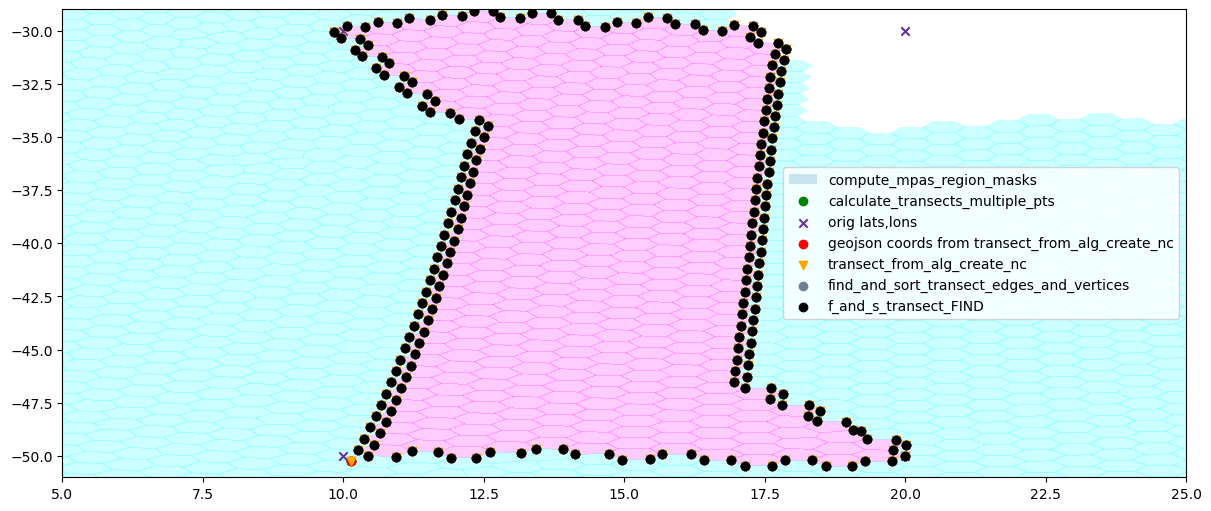

In [703]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(12,5))
# plot using vertex lats and lons (removed vertices on cells not in the mask)
vertex_lons = ds.lonVertex.isel(nVertices = np.int32(test_verts)) * 180 / np.pi # convert from radians to degrees 
vertex_lats = ds.latVertex.isel(nVertices = np.int32(test_verts)) * 180 / np.pi # convert from radians to degrees


c = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='cool',alpha = 0.2,
                  antialiaseds=False, label = 'compute_mpas_region_masks')

ax.scatter(vertex_lons,vertex_lats,c='green',label='calculate_transects_multiple_pts')
ax.scatter(lons,lats,marker='x',c='rebeccapurple',label='orig lats,lons')
ax.scatter(gj_lons, gj_lats,c='red',label='geojson coords from transect_from_alg_create_nc')
ax.scatter(test_verts_lons, test_verts_lats,marker='v',c='orange',label='transect_from_alg_create_nc')


ax.scatter(f_and_s_vertex_lons, f_and_s_vertex_lats,c='slategray',label='find_and_sort_transect_edges_and_vertices')
ax.scatter(f_verts_lons, f_verts_lats, c = 'black', label = 'f_and_s_transect_FIND')

# ax.set_ylim(-51,-25)

ax.set_ylim(-51,-29)
ax.set_xlim(5,25)

ax.legend(loc='center right')

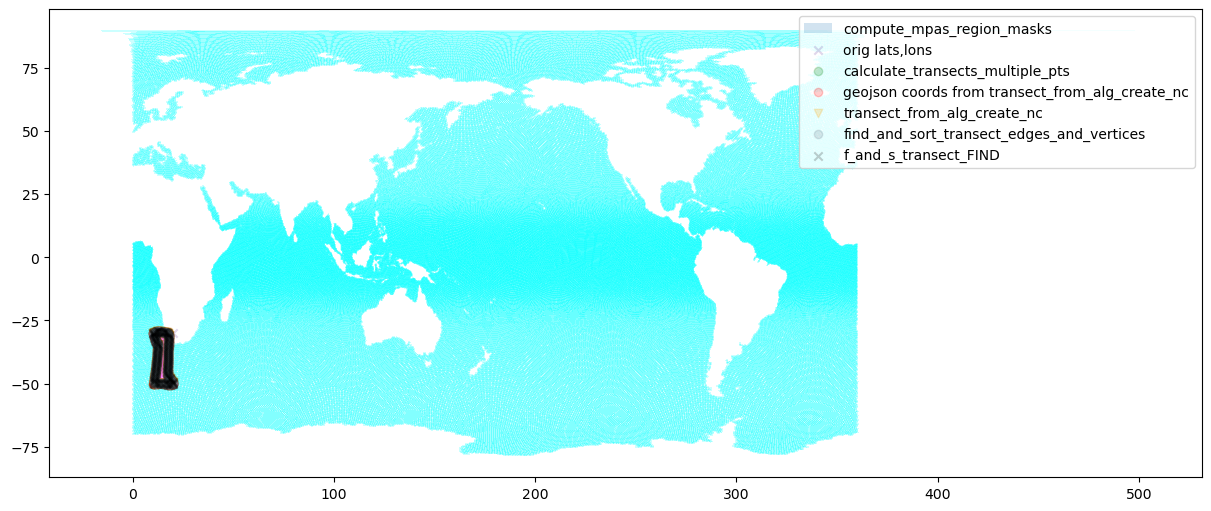

In [699]:
fig,ax = plt.subplots(nrows=1,ncols=1,constrained_layout=True,figsize=(12,5))
# plot using vertex lats and lons (removed vertices on cells not in the mask)
vertex_lons = ds.lonVertex.isel(nVertices = np.int32(test_verts)) * 180 / np.pi # convert from radians to degrees 
vertex_lats = ds.latVertex.isel(nVertices = np.int32(test_verts)) * 180 / np.pi # convert from radians to degrees


c = mosaic.polypcolor(ax,descriptor,
                  cellmask.astype(int),cmap='cool',alpha = 0.2,
                  antialiaseds=False, label = 'compute_mpas_region_masks')

ax.scatter(lons,lats,marker='x',c='rebeccapurple',label='orig lats,lons', alpha=0.2)
ax.scatter(vertex_lons,vertex_lats,c='green',label='calculate_transects_multiple_pts', alpha=0.2)
ax.scatter(gj_lons, gj_lats,c='red',label='geojson coords from transect_from_alg_create_nc', alpha=0.2)
ax.scatter(test_verts_lons, test_verts_lats,marker='v',c='orange',label='transect_from_alg_create_nc', alpha=0.2)


ax.scatter(f_and_s_vertex_lons, f_and_s_vertex_lats,c='slategray',label='find_and_sort_transect_edges_and_vertices', alpha=0.2)
ax.scatter(f_verts_lons, f_verts_lats, c = 'black', marker='x', label = 'f_and_s_transect_FIND', alpha=0.2)

# ax.set_ylim(-51,-25)

ax.set

ax.legend(loc='upper right')